In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from itertools import product
from scipy.stats import qmc  # For Latin Hypercube Sampling
import torch
import gpytorch
import random
from PIL import Image
from datetime import datetime
import scienceplots
plt.style.available
plt.style.use(['science', 'notebook'])


In [41]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, meanPrior):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if meanPrior == 'max':
            # self.mean_module = gpytorch.means.ZeroMean()
            self.mean_module = gpytorch.means.ConstantMean()
            # self.mean_module.constant = torch.nn.Parameter(torch.tensor(torch.max(train_y)))
            self.mean_module.constant.data = torch.tensor(torch.max(train_y))

        else:
            # self.mean_module = gpytorch.means.ConstantMean(constant_prior=torch.max(train_y))
            self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def GPTrain(features, targets, meanPrior):

    tensorSamplesXY = torch.from_numpy(features)
    tensorSamplesZ = torch.from_numpy(targets)

    likelihood = gpytorch.likelihoods.GaussianLikelihood() 
    model = ExactGPModel(tensorSamplesXY, tensorSamplesZ, likelihood, meanPrior)
    likelihood.noise = 1e-4
    likelihood.noise_covar.raw_noise.requires_grad_(False)

    training_iter = 250
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(tensorSamplesXY)
        # Calc loss and backprop gradients
        loss = -mll(output, tensorSamplesZ)
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #     i + 1, training_iter, loss.item(),
        #     model.covar_module.base_kernel.lengthscale.item(), #.kernels[0] after base_kernel if have multiple kernels
        #     model.likelihood.noise.item()
        # ))
        optimizer.step()
    
    return model


def GPEval(model, newFeatures):
    model.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model(torch.from_numpy(newFeatures))

    mean_pred = observed_pred.mean.numpy()

    return mean_pred

In [42]:
class DifferentialEvolution:
    def __init__(self, bounds, objective_function, pop_size=50, mutation_factor=0.8, crossover_prob=0.7, max_generations=200, method='random'):
        """
        Initialize the Differential Evolution (DE) optimizer.
        
        Parameters:
        bounds (list of tuple): List of (min, max) bounds for each dimension.
        pop_size (int): Number of candidate solutions in the population.
        mutation_factor (float): Scaling factor for mutation [0, 2].
        crossover_prob (float): Crossover probability [0, 1].
        max_generations (int): Maximum number of generations to evolve.
        method (str): Population initialization method ('random' or 'lhs').
        """
        self.bounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.pop_size = pop_size
        self.mutation_factor = mutation_factor
        self.crossover_prob = crossover_prob
        self.max_generations = max_generations
        self.method = method
        
        # Initialize population
        self.population = self.initialize_population()
        self.best_solution = None
        self.best_fitness = np.inf
        self.objective_function = objective_function
    
    def initialize_population(self):
        """Initialize population using random sampling or Latin Hypercube Sampling."""
        if self.method == 'lhs':
            # Latin Hypercube Sampling
            sampler = qmc.LatinHypercube(d=self.dimensions)
            sample = sampler.random(n=self.pop_size)
            population = qmc.scale(sample, self.bounds[:, 0], self.bounds[:, 1])
        else:
            # Random Sampling
            population = np.random.rand(self.pop_size, self.dimensions)
            for i in range(self.dimensions):
                population[:, i] = self.bounds[i, 0] + population[:, i] * (self.bounds[i, 1] - self.bounds[i, 0])
        
        # print(population.shape)
        return population
    
    def mutate(self, target_idx):
        """Mutation using DE/best/1 strategy."""
        # Choose three random and distinct individuals different from target_idx
        indices = [idx for idx in range(self.pop_size) if idx != target_idx]
        np.random.shuffle(indices)
        r1, r2 , r3= indices[:3]
        
        # Best individual in current population

        # print(self.population.shape)

        #TODO  instead of this list comprehension bollocks just evaluate them all at once
        #as thats what i think it wants, then find the minimum of the results. 


        predictedValues = GPEval(self.objective_function, self.population)

        best_idx = np.argsort(predictedValues)[:1]

        best = self.population[best_idx]

        # best_idx = np.argmin([self.objective_function.predict(ind) for ind in self.population])
        # best = self.population[best_idx]
        
        # Mutant vector: v = best + F * (r1 - r2)
        mutant = best + self.mutation_factor * (self.population[r1] - self.population[r2])
        
        # Ensure mutant vector is within bounds
        mutant = np.clip(mutant, self.bounds[:, 0], self.bounds[:, 1])
        
        return mutant
    
    def crossover(self, target, mutant):
        """Crossover to create trial vector."""
        trial = np.copy(target)
        # print(trial.shape)
        # print(mutant.shape)
        for i in range(self.dimensions):
            if np.random.rand() < self.crossover_prob or i == np.random.randint(self.dimensions):
                # print(trial[i], mutant[i])
                trial[i] = mutant[i]
        return trial
    
    # def select(self, target, trial):
    #     """Selection: Return the individual with the better fitness."""
    #     if self.objective_function.predict(trial) < self.objective_function.predict(target):
    #         return trial
    #     return target

    def select(self, target, trial):
        """Selection: Return the individual with the better fitness."""
        
        if GPEval(self.objective_function, trial) < GPEval(self.objective_function, target):
            return trial
        return target
    
    def optimize(self):
        """Run the Differential Evolution optimization."""
        # x_range = np.linspace(-5, 5, 100)
        # y_range = np.linspace(-5, 5, 100)
        # X, Y = np.meshgrid(x_range, y_range)
        # Z = ackley_function(X, Y)
        x_range = np.linspace(self.bounds[0,0], self.bounds[0,1],50)
        y_range = np.linspace(self.bounds[1,0], self.bounds[1,1],50)
        fullRange = list(product(x_range, y_range))
        fullRangeArray = np.array(fullRange)
        # y_pred = self.objective_function.predict(fullRangeArray)
        y_pred = GPEval(self.objective_function, fullRangeArray)

        for generation in range(self.max_generations):
            new_population = np.zeros_like(self.population)
            allTrials = np.zeros_like(self.population)
            allTargets = np.zeros_like(self.population)
            # print(self.population.shape)
            for i in range(self.pop_size):
                target = self.population[i]
                # print('break')
                # print(i)
                mutant = self.mutate(i)
                # print(mutant)
                mutant = np.reshape(mutant, (2,))
                # print(mutant)
                trial = self.crossover(target, mutant)
                trial = np.reshape(trial, (1,-1))
                target = np.reshape(target, (1,-1))
                # print('for select', trial.shape, target.shape)
                new_population[i] = self.select(target, trial)
            
            # Update the population
            self.population = new_population
            
            # Track the best solution
            # best_idx = np.argmin([self.objective_function.predict(ind) for ind in self.population])
            # best_fitness = self.objective_function.predict(self.population[best_idx])
            
            # predictedValues = self.objective_function.predict(self.population)
            predictedValues = GPEval(self.objective_function, self.population)

            best_idx = np.argsort(predictedValues)[:1]

            # best_fitness = self.objective_function.predict(self.population[best_idx])
            best_fitness = GPEval(self.objective_function, self.population[best_idx])

            if best_fitness < self.best_fitness:
                self.best_fitness = best_fitness
                self.best_solution = self.population[best_idx]
            
            # plt.contourf(x_range, y_range, y_pred, levels=50, cmap='viridis')
        # plt.scatter(fullRangeArray[:,0], fullRangeArray[:,1], c = y_pred)

        # plt.scatter(self.population[:, 0], self.population[:, 1], color='red', label='Final Population', s=5)
        # # plt.scatter(best_solution[0], best_solution[1], color='blue', label='Best Solution', s=100)
        # # plt.legend()
        # plt.title("Local Surrogate")
        # plt.colorbar()
        # plt.clim(0,14)
        # plt.xlim(self.bounds[0,0], self.bounds[0,1])
        # plt.ylim(self.bounds[1,0], self.bounds[1,1])
        # # plt.savefig('localGP.png')
        # plt.show()
        # # # Debug information
        # print(f"Generation {generation + 1}: Best RBF Fitness = {self.best_fitness}")
        
        return self.best_solution, self.best_fitness

In [43]:
def ackley_function(x, y, a=20, b=0.2, c=2 * np.pi):
    term1 = -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(c * x) + np.cos(c * y)))
    return term1 + term2 + a + np.exp(1)

def objective_function(vec):
    """Objective function wrapper for optimization.
    Args:
        vec (np.ndarray): A vector representing candidate solution (x, y).
    Returns:
        float: Fitness value of the solution.
    """
    x, y = vec
    return ackley_function(x, y)

In [44]:
class ESA:
    def __init__(self, bounds, pop_size, localPopSize, alpha, gamma, maxFE, mutation_factor=0.8, crossover_prob=0.7):

        self.globalBounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.pop_size = pop_size
        self.feFeatures = np.empty((0,2))
        self.feTargets = np.empty(0) 
        # self.k = k
        self.population = self.initialiseDatabase()
        self.localPopSize = localPopSize

        #initialise 4actions x 8states array, all entries initialised to 0.25
        self.qTable = np.full((8,4), 0.1)
        self.x_best = 0
        self.x_bestSolution = 0
        self.alpha = alpha
        self.gamma = gamma
        self.maxFE = maxFE
        self.mutation_factor = mutation_factor
        self.crossover_prob = crossover_prob

    def initialiseDatabase(self):

        sampler = qmc.LatinHypercube(d=self.dimensions)
        sample = sampler.random(n=self.pop_size)
        population = qmc.scale(sample, self.globalBounds[:, 0], self.globalBounds[:, 1])

        for i in range(0, len(population)):
            self.feTargets = np.append(self.feTargets, objective_function(population[i]))
            self.feFeatures = np.vstack((self.feFeatures, population[i]))

        plt.scatter(self.feFeatures[:,0], self.feFeatures[:,1], c = self.feTargets)
        plt.title('Initial Population')
        plt.colorbar()
        plt.show()

        return population
    
    
    def mutate(self, target_idx):
        """Mutation using DE/best/1 strategy."""
        # Choose three random and distinct individuals different from target_idx
        indices = [idx for idx in range(self.pop_size) if idx != target_idx]
        np.random.shuffle(indices)
        r1, r2 , r3= indices[:3]
        
        # Best individual in current population
        best_idx = np.argmin([objective_function(ind) for ind in self.population])
        best = self.population[best_idx]
        
        # Mutant vector: v = best + F * (r1 - r2)
        mutant = best + self.mutation_factor * (self.population[r1] - self.population[r2])
        
        # Ensure mutant vector is within bounds
        mutant = np.clip(mutant, self.globalBounds[:, 0], self.globalBounds[:, 1])
        
        return mutant
    
    def crossover(self, target, mutant):
        """Crossover to create trial vector.
        This loops through the features in the vector (dimensions) and sees if any of them crossover. 
        allows the retention of some original vector features but not others. 
        """

        trial = np.copy(target)
        # print(trial.shape)
        # print(mutant.shape)
        for i in range(self.dimensions):
            if np.random.rand() < self.crossover_prob or i == np.random.randint(self.dimensions):
                # print(trial[i], mutant[i])

                trial[i] = mutant[i]
        return trial
    
    def runNextAction(self, currentAction):

        if currentAction == 0:
            print('Running a1!')
            newBestFeature, newBestTarget = self.a1()

            if newBestTarget < self.x_bestSolution:
                self.x_bestSolution = newBestTarget
                currentState = 1
                r = 1
            
            else:
                currentState = 0
                r=0

        if currentAction == 1:
            print('Running a2!')

            newBestFeature, newBestTarget = self.a2()

            if newBestTarget < self.x_bestSolution:
                self.x_bestSolution = newBestTarget
                currentState = 3
                r = 1
            
            else:
                currentState = 2
                r=0

        if currentAction == 2:
            print('Running a3!')

            newBestFeature, newBestTarget = self.a3()

            if newBestTarget < self.x_bestSolution:
                self.x_bestSolution = newBestTarget
                currentState = 5
                r = 1
            
            else:
                currentState = 4
                r=0
            
        if currentAction == 3:
            print('Running a4!')

            newBestFeature, newBestTarget = self.a4()

            if newBestTarget < self.x_bestSolution:
                self.x_bestSolution = newBestTarget
                currentState = 7
                r = 1
            
            else:
                currentState = 6
                r=0

        return currentState, r, newBestTarget

    def mainMenu(self, initialAction):
        '''
        handle all the q-value and q-table stuff here
        such as calculating rewards, probabilities of selecting next states,
        and running the next algorithm

        set initialAction to be a random number (from 0-3) to select initial algorithm to use
        '''

        bestIndex = np.argmin(self.feTargets)
        self.x_best = self.feFeatures[bestIndex]

        self.x_bestSolution = self.feTargets[bestIndex]

        currentAction = initialAction

        currentState, r, mostRecentValue = self.runNextAction(currentAction)

        #calculate softmax selection strategy

        actions = np.arange(4)


        #loop from here?
        iteration = 0
        while iteration < self.maxFE:

            actionProb = np.empty((1,4))

            for i in range(0,4):

                actionProb[0,i] = (np.exp(self.qTable[currentState, i])) / np.sum(np.exp(self.qTable[currentState]))

            previousState = currentState

            # Select an action based on the probabilities in actionProb[1]
            next_action = np.random.choice(actions, p=actionProb[0])

            currentState, r, mostRecentValue = self.runNextAction(next_action)
            print('At iteration: ', iteration, ' current state: ' , currentState)

            #calculate the new q value for the action taken in the PREVIOUS state

            self.qTable[previousState, next_action] += self.alpha * (r + (self.gamma * np.max(self.qTable[currentState,:]))
                                                                    - self.qTable[previousState, next_action])
            
            print('QTable at iteration ', iteration)
            print(self.qTable)

            if iteration % 5 == 0:
                        plt.scatter(self.feFeatures[:,0], self.feFeatures[:,1], c = self.feTargets)
                        plt.title(f'Population at iteration {iteration}')
                        plt.colorbar()
                        plt.savefig(f'ESAIteration{iteration}.png')

                        plt.close()

            print(f'Best result at iteration {iteration}', self.x_bestSolution)

            fig, ax = plt.subplots()
            cax = ax.matshow(np.ndarray.transpose(self.qTable), cmap="binary", vmin = 0, vmax = 1, aspect=1)

            # Add color bar to show scale
            fig.colorbar(cax)
            
            # Set custom tick labels for x and y axes
            x_labels = ['1', '2', '3', '4', '5', '6', '7', '8']  # 8 columns
            y_labels = ['A1', 'A2', 'A3', 'A4']       # 4 rows

            ax.set_xticks(np.arange(len(x_labels)))  # Set x-ticks to match number of columns
            ax.set_yticks(np.arange(len(y_labels)))  # Set y-ticks to match number of rows
            ax.tick_params(top=True, labeltop=True, labelbottom=False, bottom=False)

            ax.set_xticklabels(x_labels)  # Set x-tick labels
            ax.set_yticklabels(y_labels)  # Set y-tick labels

            ax.set_xlabel('State' )
            ax.xaxis.set_label_position('top')
            ax.set_ylabel("Action")
            # Add grid
            ax.set_xticks(np.arange(-0.5, len(x_labels), 1), minor=True)
            ax.set_yticks(np.arange(-0.5, len(y_labels), 1), minor=True)
            ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
            ax.tick_params(which="minor", size=0)  # Hide minor ticks but keep grid
            plt.text(-0.5,4,f'Previous State = {previousState + 1}')
            plt.text(-0.5,4.5,f'Previous Action = {next_action + 1}')
            plt.text(-0.5,5,f'Reward = {r}')
            plt.text(3,4,f'Current Best Value = {round(self.x_bestSolution, 5)}')
            plt.text(3,5,f'Last Found Value = {round(mostRecentValue, 5)}')

            plt.savefig(f"ESAQTablePlots/{iteration}.png")
            plt.close()

            iteration += 1

        #algorithm:
        #select initial action randomly
        #run action to determine initial state, updating no values yet
        #choose new action and run algorithm. This gives FIRST state-action pair
        #depending on result, update q value for state action pair. 
        #repeat. 


        

    def a1(self):

        new_population = np.zeros_like(self.population)
            
        for i in range(self.pop_size):
            # print(i)
            target = self.population[i]
            mutant = self.mutate(i)
            trial = self.crossover(target, mutant)
            #do not evaluate target/trial vectors, instead just save the trial vectors as the new population
            #so they can be evaluated on the global RBF and Lipschitz surrogates later
            # new_population[i] = self.select(target, trial)
            new_population[i] = trial
            
            # Update the population
        self.population = new_population
        # print(new_population.shape)
        # pairwise_distances = np.linalg.norm(self.feFeatures[:,np.newaxis] - self.feFeatures, axis=2)
        # avg_distance = np.mean(pairwise_distances)
        # globalRBF = RBFSurrogateModel(epsilon=1.0)

        # globalRBF.fit(self.feFeatures, self.feTargets)

        GPModel = GPTrain(self.feFeatures, self.feTargets, meanPrior='zero')

        popOnGP = GPEval(GPModel, self.population)

        
        #evaluating whole landscape on RBF for plotting reasons:
        x_range = np.linspace(-5,5,50)
        y_range = np.linspace(-5,5,50)
        fullRange = list(product(x_range, y_range))
        fullRangeArray = np.array(fullRange)
        y_pred = GPEval(GPModel, fullRangeArray)


        #evaluate current population (children) on RBF
        # popOnRBF = globalRBF.predict(self.population)

        #function evaluation of best predicted child
        best_idx = np.argmin(popOnGP)

        bestFeature = self.population[best_idx]

        # print('best index =', best_idx)
        #evaluate best child and add results to global stores of FE features and targets
        self.feTargets = np.append(self.feTargets, objective_function(self.population[best_idx]))
        self.feFeatures = np.vstack((self.feFeatures, self.population[best_idx]))

        return self.feFeatures[-1], self.feTargets[-1]

    
    def a2(self):

        
        bestFeatures = np.empty((self.localPopSize,2))
        bestTargets = np.empty(self.localPopSize)

        #find c best solutions
        bestIndices = np.argsort(self.feTargets)[:self.localPopSize]

        for i in range(self.localPopSize):
            bestFeatures[i] = self.feFeatures[bestIndices[i]]
            bestTargets[i] = self.feTargets[bestIndices[i]]




        x_min, x_max = np.min(bestFeatures[:, 0]), np.max(bestFeatures[:, 0])
        y_min, y_max = np.min(bestFeatures[:, 1]), np.max(bestFeatures[:, 1])

        bounds = [(x_min, x_max), (y_min, y_max)]

        # pairwiseDistancesLocal = np.linalg.norm(bestFeatures[:, np.newaxis] - bestFeatures, axis=2)
        # avgDistanceLocal = np.mean(pairwiseDistancesLocal)

        localGP = GPTrain(bestFeatures, bestTargets, meanPrior='max')

        # localRBF = RBFSurrogateModel(epsilon=1.0)
        # localRBF.fit(bestFeatures, bestTargets)

        # functionEval = localRBF.predict()
        localDE = DifferentialEvolution(bounds, localGP )
        bestLocalSolution, bestLocalFitness = localDE.optimize()
        bestLocalSolution = np.reshape(bestLocalSolution, (2,))

        self.feTargets = np.append(self.feTargets, objective_function(bestLocalSolution))
        self.feFeatures = np.vstack((self.feFeatures, bestLocalSolution)) 

        #TODO
        #add in step to evaluate best found solution on objective function and return:
        return self.feFeatures[-1], self.feTargets[-1]



    def a3(self):

        #build surrogate using all points in population
        crossoverGP = GPTrain(self.feFeatures, self.feTargets, meanPrior='zero')

        best_idx = np.argmin(self.feTargets)
        bestFeature = self.feFeatures[best_idx]
        bestTarget = self.feTargets[best_idx]

        RVS = random.sample(range(0, self.dimensions), self.dimensions)

        # print(self.feFeatures.shape)
        # print(bestFeature)

        tempPop = np.full_like((self.feFeatures), bestFeature)

        # print(tempPop)

        for i in RVS:
            # print(i)

            tempPop[:,i] = self.feFeatures[:,i]

            tempPopEval = GPEval(crossoverGP, tempPop)

            tempPopBestIdx = np.argmin(tempPopEval)
            if tempPopEval[tempPopBestIdx] > bestTarget:
                tempPop = np.full_like((self.feFeatures), tempPop[tempPopBestIdx])
                # print('new best value!')

        #take final best predicted value and explicitely evaluate
        self.feTargets = np.append(self.feTargets, objective_function(tempPop[tempPopBestIdx]))
        self.feFeatures = np.vstack((self.feFeatures, tempPop[tempPopBestIdx]))

        return self.feFeatures[-1], self.feTargets[-1]


    def find_closest_points(self, points, selected_point_index, n):
        # Convert points to a NumPy array for easier manipulation
        # points = np.array(points)
        
        # Get the selected point from the array
        selected_point = points[selected_point_index]
        
        # Calculate the Euclidean distance from the selected point to each other point
        distances = np.linalg.norm(points - selected_point, axis=1)
        
        # Exclude the selected point itself by setting its distance to infinity
        distances[selected_point_index] = np.inf
        
        # Find the indices of the n smallest distances
        closest_indices = np.argpartition(distances, n)[:n]
        
        # Get the n closest points
        closest_points = points[closest_indices]
        
        return closest_points
    
    
    def a4(self):

        iteration = 0

        while iteration < 3:

            print('iteration = ', iteration)

            #this handles x_best updating
            bestIndex = np.argmin(self.feTargets)
            x_best = self.feFeatures[bestIndex]

            x_bestSolution = self.feTargets[bestIndex]

            if iteration == 0:

                nPoints = self.dimensions * 5

                closestPoints = self.find_closest_points(self.feFeatures, bestIndex, nPoints)

                x_min, x_max = np.min(closestPoints[:, 0]), np.max(closestPoints[:, 0])
                y_min, y_max = np.min(closestPoints[:, 1]), np.max(closestPoints[:, 1])

                # print('x min max', x_min, x_max)
                # print('y min max', y_min, y_max)


                sigma = np.empty((1,self.dimensions))

                # print(sigma.shape)

                #hard coded to two dimensions for now
                sigma[0,0] = ((x_max - x_min)/2)
                sigma[0,1] = ((y_max) - (y_min)/2)

                # print('sigma', sigma)

                # print('xbest', x_best)

            lower_bound_trust = x_best - sigma
            upper_bound_trust = x_best + sigma

            # print('lower bound trust shape:  ', lower_bound_trust.shape)
    
            # print(lower_bound_trust)

            trustRegionBounds = [(lower_bound_trust[0,0], upper_bound_trust[0,0]), (lower_bound_trust[0,1], upper_bound_trust[0,1])]


            in_area = (self.feFeatures[:, 0] >= lower_bound_trust[0,0]) & (self.feFeatures[:, 0] <= upper_bound_trust[0,0]) & \
                    (self.feFeatures[:, 1] >= lower_bound_trust[0,1]) & (self.feFeatures[:, 1] <= upper_bound_trust[0,1])
            
            # print(in_area)

            #in_area is a 'boolean mask', which evaluates to True if all above conditions are achieved. 
            #when setting the points below it automatically chooses only ones which are true. 

            trustRegionFeatures = self.feFeatures[in_area]
            trustRegionTargets = self.feTargets[in_area]

            try:
            #build surrogate on points in the trust region
                trustRegionGP = GPTrain(trustRegionFeatures, trustRegionTargets, meanPrior='max')

                trustRegionDE = DifferentialEvolution(trustRegionBounds, trustRegionGP)
                trustBestSolution, trustBestFitness = trustRegionDE.optimize()

                trustBestSolution = np.reshape(trustBestSolution, (2,))

                # print('trust region best Solution', trustBestSolution)


                trustBestFE =  objective_function(trustBestSolution)

                self.feTargets = np.append(self.feTargets, objective_function(trustBestSolution))
                self.feFeatures = np.vstack((self.feFeatures, trustBestSolution)) 

                #calculate trust ratio

                rho_k = (x_bestSolution - trustBestFE)/(x_bestSolution - trustBestFitness)

                # print('rho_k = ', rho_k)
                # print('old sigma =', sigma)

                epsilon = 1.5

                if rho_k < 0.25:
                    sigma = 0.25 * sigma

                elif rho_k > 0.25 and rho_k < 0.75:
                    sigma = sigma #is there something smarter i can do?

                elif rho_k > 0.75:
                    sigma = epsilon * sigma

                # print('new sigma = ', sigma)

                # plt.scatter(self.feFeatures[:,0], self.feFeatures[:,1], c = self.feTargets)
                # plt.title('Evaluated Population')
                # plt.colorbar()
                # plt.show()

                iteration += 1
            except RuntimeError:
                print('Error in training GP Surrogate, skipping...')
                iteration +=1
            
            #return however many iterations worth of features/targets
        return self.feFeatures[-1], self.feTargets[-1]



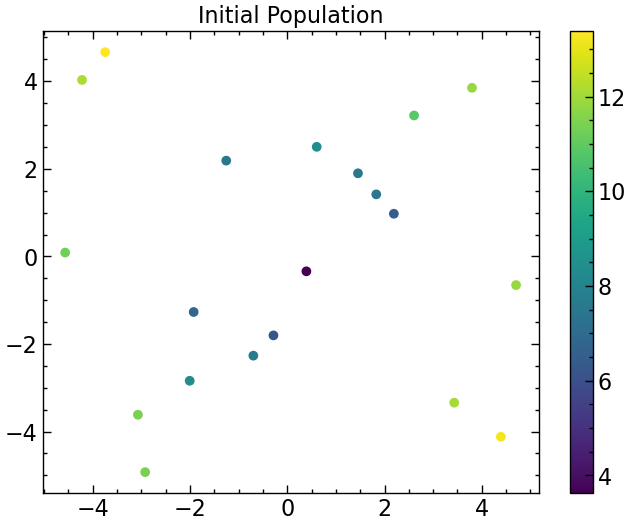

Running a1!
Running a4!
iteration =  0


/var/folders/8p/wlgb17ln00dg_lln7zq_3gpw0000gn/T/ipykernel_2232/4061782729.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean_module.constant.data = torch.tensor(torch.max(train_y))


iteration =  1
iteration =  2
At iteration:  0  current state:  7
QTable at iteration  0
[[0.1    0.1    0.1    0.3475]
 [0.1    0.1    0.1    0.1   ]
 [0.1    0.1    0.1    0.1   ]
 [0.1    0.1    0.1    0.1   ]
 [0.1    0.1    0.1    0.1   ]
 [0.1    0.1    0.1    0.1   ]
 [0.1    0.1    0.1    0.1   ]
 [0.1    0.1    0.1    0.1   ]]
Best result at iteration 0 3.6243477743956345
Running a1!
At iteration:  1  current state:  0
QTable at iteration  1
[[0.1       0.1       0.1       0.3475   ]
 [0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1      ]
 [0.1531875 0.1       0.1       0.1      ]]
Best result at iteration 1 3.6243477743956345
Running a3!
At iteration:  2  current state:  4
QTable at iteration  2
[[0.1       0.1       0.0975    0.3475   ]
 [0.1       0.1       0.1       0.1     

KeyboardInterrupt: 

In [45]:
bounds = [(-5,5), (-5,5)] #bounds for each dimension (x and y)

ESA = ESA(bounds, 20, 10, 0.25, 0.9, 150)
ESA.mainMenu(initialAction=0)

Text(4, 4, 'Reward = ')

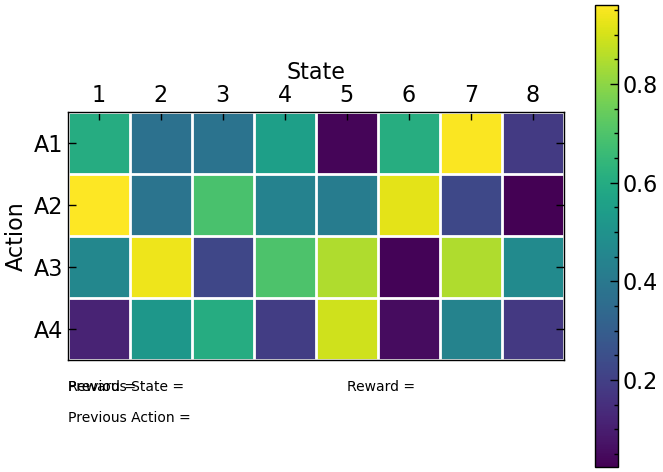

In [ ]:
data = np.random.rand(4,8)

# Set up the figure and axis
fig, ax = plt.subplots()
cax = ax.matshow(data, cmap="viridis", aspect=1)

# Add color bar to show scale
fig.colorbar(cax)
# Set custom tick labels for x and y axes
x_labels = ['1', '2', '3', '4', '5', '6', '7', '8']  # 8 columns
y_labels = ['A1', 'A2', 'A3', 'A4']       # 4 rows

ax.set_xticks(np.arange(len(x_labels)))  # Set x-ticks to match number of columns
ax.set_yticks(np.arange(len(y_labels)))  # Set y-ticks to match number of rows
ax.tick_params(top=True, labeltop=True, labelbottom=False, bottom=False)

ax.set_xticklabels(x_labels)  # Set x-tick labels
ax.set_yticklabels(y_labels)  # Set y-tick labels

ax.set_xlabel('State' )
ax.xaxis.set_label_position('top')
ax.set_ylabel("Action")
# Add grid
ax.set_xticks(np.arange(-0.5, len(x_labels), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(y_labels), 1), minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", size=0)  # Hide minor ticks but keep grid
plt.text(-0.5,4,'Previous State = ')
plt.text(-0.5,4.5,'Previous Action = ')
plt.text(-0.5,4,'Reward = ')
plt.text(4,4,'Reward = ')




In [ ]:
import glob
import imageio
import os

image_files = sorted(glob.glob("ESAQTablePlots/*.png"), key=os.path.getmtime)
print(image_files)

images = [Image.open(img) for img in image_files]

# Step 3: Save images as a GIF
if images:
    # 'duration' is the time each frame stays on screen (milliseconds)
    images[0].save(
        "ESABaWNew.gif",
        save_all=True,
        append_images=images[1:],  # Include the rest of the images
        duration=400,               # Duration of each frame in milliseconds
        loop=0                       # 0 means loop indefinitely
    )

['ESAQTablePlots/0.png', 'ESAQTablePlots/1.png', 'ESAQTablePlots/2.png', 'ESAQTablePlots/3.png', 'ESAQTablePlots/4.png', 'ESAQTablePlots/5.png', 'ESAQTablePlots/6.png', 'ESAQTablePlots/7.png', 'ESAQTablePlots/8.png', 'ESAQTablePlots/9.png', 'ESAQTablePlots/10.png', 'ESAQTablePlots/11.png', 'ESAQTablePlots/12.png', 'ESAQTablePlots/13.png', 'ESAQTablePlots/14.png', 'ESAQTablePlots/15.png', 'ESAQTablePlots/16.png', 'ESAQTablePlots/17.png', 'ESAQTablePlots/18.png', 'ESAQTablePlots/19.png', 'ESAQTablePlots/20.png', 'ESAQTablePlots/21.png', 'ESAQTablePlots/22.png', 'ESAQTablePlots/23.png', 'ESAQTablePlots/24.png', 'ESAQTablePlots/25.png', 'ESAQTablePlots/26.png', 'ESAQTablePlots/27.png', 'ESAQTablePlots/28.png', 'ESAQTablePlots/29.png', 'ESAQTablePlots/30.png', 'ESAQTablePlots/31.png', 'ESAQTablePlots/32.png', 'ESAQTablePlots/33.png', 'ESAQTablePlots/34.png', 'ESAQTablePlots/35.png', 'ESAQTablePlots/36.png', 'ESAQTablePlots/37.png', 'ESAQTablePlots/38.png', 'ESAQTablePlots/39.png', 'ESAQTabl